##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/audio/transfer_learning_audio"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.orgで表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/audio/transfer_learning_audio.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">GoogleColabで実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/audio/transfer_learning_audio.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHubで表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/audio/transfer_learning_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロードする</a></td>
  <td><a href="https://tfhub.dev/google/yamnet/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TFハブモデルを参照してください</a></td>
</table>

# YAMNetを用いた転移学習による環境音分類

[YAMNet](https://tfhub.dev/google/yamnet/1) は、笑い声、動物の吠える声、サイレン音などを含む [521 種](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv)の音声イベントを予測できるトレーニング済みのディープニューラルネットワークです。

このチュートリアルでは次の方法について学ぶことができます:

- YAMNetをロードし、推論に利用する
- YAMNetのエンベディングを利用した新しいモデルを作成し、猫と犬の音を分類する
- 作成したモデルを評価しエクスポートする


## <br>TensorFlow およびその他のライブラリのインポート


まず、[TensorFlow I / Oを](https://www.tensorflow.org/io)インストールすることから始めます。これにより、オーディオファイルをディスクから簡単にロードできるようになります。

In [2]:
!pip install -q "tensorflow==2.11.*"
# tensorflow_io 0.28 is compatible with TensorFlow 2.11
!pip install -q "tensorflow_io==0.28.*"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.3 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.


In [3]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

2024-01-11 22:04:30.617491: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


2024-01-11 22:04:31.269076: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-11 22:04:31.269179: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-11 22:04:31.269189: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## YAMNetについて

[YAMNet](https://github.com/tensorflow/models/tree/master/research/audioset/yamnet) は、[MobileNetV1](https://arxiv.org/abs/1704.04861) という深さ方向に分離可能な畳み込みアーキテクチャを使用するトレーニング済みのニューラルネットワークです。音声の波形を入力として使用し、[AudioSet](http://g.co/audioset) コーパスの 521 種の各音声イベントに対して個別の予測を行えます。

内部的には、モデルは音声信号から「フレーム」を抽出し、これらのフレームをバッチ処理します。このバージョンのモデルは長さが 0.96 秒のフレームを使用し、0.48 秒ごとに 1 つのフレームを抽出します。

モデルは、値域 `[-1.0, +1.0]` の単精度 16 kHz サンプルとして表される、任意の長さの波形を、1-D float32 テンソルまたは NumPy 配列で受け入れます。このチュートリアルには、WAV ファイルをサポートされたフォーマットに変換するのに役立つコードが含まれています。

モデルは、クラススコア、埋め込み（転移学習に使用）、およびログメル[スペクトログラム](https://www.tensorflow.org/tutorials/audio/simple_audio#spectrogram)を含む 3 つの出力を返します。詳細については、[こちら](https://tfhub.dev/google/yamnet/1)をご覧ください。

YAMNet には、高レベル特徴量抽出器（1,024 次元埋め込み出力）としての特定の使用方法があります。ベース（YAMNet）モデルの入力特徴量を使用して、それらを、1 つの `tf.keras.layers.Dense` という非表示レイヤーで構成されるより浅いモデルにフィードします。その後、ネットワークを*多数のラベル付きデータを使ったりエンドツーエンドでトレーニングすることなく*、少量のデータで音声分類トレーニングを行います。（これは[TensorFlow Hub を使った画像分類の転移学習](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub)に似ています。詳しくはそちらをご覧ください。）

それでは、モデルをテストし、音声の分類結果を確認してみましょう。その後、データの前処理パイプラインを構築していきます。

### TensorFlowハブからYAMNetを読み込む

[Tensorflow Hub](https://tfhub.dev/) にある事前トレーニング済みの YAMNet を使用して、サウンドファイルから埋め込みを抽出します。

TensorFlow Hubからモデルをロードするのは簡単です。モデルを選択し、そのURLをコピー、そして `load`関数を使用します。

注意: モデルからドキュメントを読み取るには、ブラウザにモデルの URL を入力してください。

In [4]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

2024-01-11 22:04:33.491270: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-11 22:04:33.491378: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-01-11 22:04:33.491445: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-01-11 22:04:33.491506: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2024-01-11 22:04:33.549501: W tensorfl

モデルが読み込まれたら、[YAMNet の基本的な使用に関するチュートリアル](https://www.tensorflow.org/hub/tutorials/yamnet)に従って、推論を実行するサンプル WAV ファイルをダウンロードします。


In [5]:
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)

  8192/215546 [>.............................] - ETA: 0s

215546/215546 [==============================] - 0s 0us/step


./test_data/miaow_16k.wav


音声ファイルの読み込む関数が必要です。この関数は、後でトレーニングデータを操作する際にも使用します。（音声ファイルとラベルの読み取りに関する詳細は、[単純な音声の認識](https://www.tensorflow.org/tutorials/audio/simple_audio#reading_audio_files_and_their_labels)をご覧ください。）

注意: `load_wav_16k_mono` から返される `wav_data` はすでに `[-1.0, 1.0]` の値域に正規化されています（詳細は、[TF Hub にある YAMNet のドキュメント](https://tfhub.dev/google/yamnet/1)をご覧ください）。

In [6]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


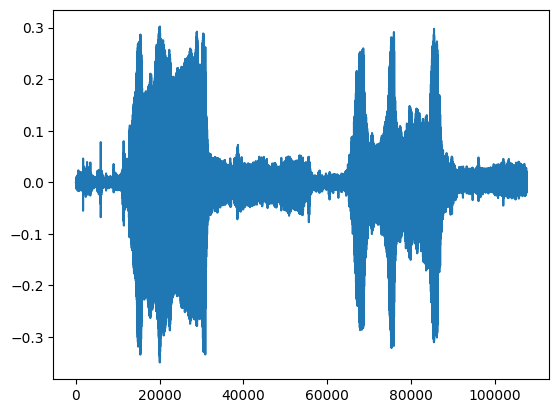

In [7]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)

### クラスマッピングのロード

読み込むクラス名は YAMNet が認識できるものであることが重要です。マッピングファイルは CSV 形式で `yamnet_model.class_map_path()` にあります。

In [8]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


### 推論の実行

YAMNet は、フレームレベルのクラススコア（フレームごとに 521 個のスコア）を提供します。クリップレベルでの予測を決定するために、スコアをフレーム全体でクラスごとに集計することができます（平均または最大集計などを使用します）。これは、`scores_np.mean(axis=0)` によって以下のように行われます。最後に、クリップレベルで最高スコアのクラスを見つけるには、521 個の集計スコアの最大値を取得します。


In [9]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Animal
The embeddings shape: (13, 1024)


注意: モデルは動物の声や音を正しく推論しました。このチュートリアルでの目標は、モデルの特定のクラスの精度を上げることです。また、モデルがフレームごとに 1 つの埋め込み（計 13 個の埋め込み）を生成したことにも注意してください。

## ESC-50 dataset

[ESC-50 データセット](https://github.com/karolpiczak/ESC-50#repository-content)（[Piczak, 2015](https://www.karolpiczak.com/papers/Piczak2015-ESC-Dataset.pdf)）は、5 秒の長さの環境音声データが 2,000 個含まれるラベル付きのコレクションです。データセットは 50 個のクラスと、クラス当たり 40 個の Example で構成されています。

データセットをダウンロードして抽出します。


In [10]:
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

   8192/Unknown - 0s 0us/step

### データの観察

<br>各ファイルのメタデータは次のcsvファイルで指定されています。 `./datasets/ESC-50-master/meta/esc50.csv`<br>

また、すべてのオーディオファイルは次のディレクトリにあります。<br>`.datasets/ESC-50-master/audio/`

マッピングを使用して pandas `DataFrame` を作成し、それを使用してデータをよりわかりやすく表示します。


In [11]:
esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

### データのフィルタリング

データが `DataFrame` に格納されたので、変換を適用しましょう。

- 行をフィルタリングして、選択したクラス（`dog` と `cat`）のみを使用します。他のクラスを使用する場合は、ここで選択してください。
- 後での読み込み作業を簡単に行えるように、ファイル名をフルパスに変更します。
- ターゲットを特定の範囲内に変更します。この例では、`dog` は `0` の位置のままですが、`cat` は元の `5` の値から `1` に変わります。

In [12]:
my_classes = ['dog', 'cat']
map_class_to_id = {'dog':0, 'cat':1}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

filename  fold  target category  \
0    ./datasets/ESC-50-master/audio/1-100032-A-0.wav     1       0      dog   
14   ./datasets/ESC-50-master/audio/1-110389-A-0.wav     1       0      dog   
157   ./datasets/ESC-50-master/audio/1-30226-A-0.wav     1       0      dog   
158   ./datasets/ESC-50-master/audio/1-30344-A-0.wav     1       0      dog   
170   ./datasets/ESC-50-master/audio/1-32318-A-0.wav     1       0      dog   
175   ./datasets/ESC-50-master/audio/1-34094-A-5.wav     1       1      cat   
176   ./datasets/ESC-50-master/audio/1-34094-B-5.wav     1       1      cat   
229   ./datasets/ESC-50-master/audio/1-47819-A-5.wav     1       1      cat   
230   ./datasets/ESC-50-master/audio/1-47819-B-5.wav     1       1      cat   
231   ./datasets/ESC-50-master/audio/1-47819-C-5.wav     1       1      cat   

     esc10  src_file take  
0     True    100032    A  
14    True    110389    A  
157   True     30226    A  
158   True     30344    A  
170   True     32318    A  
175  False     34094    A  
176  False     34094    B  
229  False     47819    A  
230  False     47819    B  
231  False     47819    C

### オーディオファイルのロードとエンベディングの取得

ここでは、`load_wav_16k_mono` を適用して、モデルに使用する WAV データを準備します。

WAV データから埋め込みを抽出すると、形状 `(N, 1024)` の配列が得られます。`N` は、YAMNet が検出したフレーム数です（音声の 0.48 秒あたり 1 フレーム）。

このモデルは角フレームを 1 つの入力として使用するため、1 行当たり 1つのフレームを持つ新しい列を作成する必要があります。また、新しい行を正しく反映させるために、ラベルと `fold` 列を拡張する必要もあります。

拡張された `fold` 列には元の値が保持されます。分割を行う際に異なる Split に同じ音声が含まれてしまう可能性があり、検証とテストのステップの効果が低くなってしまうため、フレームを混ぜることはできません。

In [13]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [14]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [15]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

### データの分割

`fold` 列を使って、データセットをテストセット、検証セット、テストセットに分割します。

ESC-50 は、同じ元のソースが必ず同じ `fold` に含まれるように、5 つの均一なサイズの相互検証 `fold` に構成されます。詳細は、『[ESC: Dataset for Environmental Sound Classification](https://www.karolpiczak.com/papers/Piczak2015-ESC-Dataset.pdf)』論文をご覧ください。

最後のステップでは、データセットから `fold` 列を削除します。この列は、トレーニング中に使用されません。


In [16]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

## モデルの作成

ここまでで、ほとんどの作業を終えました！次は、1 つの非表示レイヤーと 2 つの出力でサウンドから犬と猫を識別する非常に単純な [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) モデルを定義します。


In [17]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 512)               524800    


 dense_1 (Dense)             (None, 2)                 1026      


Total params: 525,826


Trainable params: 525,826


Non-trainable params: 0


_________________________________________________________________


In [18]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [19]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20


      1/Unknown - 4s 4s/step - loss: 0.7729 - accuracy: 0.6250

     12/Unknown - 4s 5ms/step - loss: 0.9245 - accuracy: 0.8438

15/15 [==============================] - 5s 42ms/step - loss: 0.8131 - accuracy: 0.8417 - val_loss: 0.2044 - val_accuracy: 0.9187


Epoch 2/20


 1/15 [=>............................] - ETA: 0s - loss: 0.1675 - accuracy: 0.8750

15/15 [==============================] - 0s 5ms/step - loss: 0.3020 - accuracy: 0.8979 - val_loss: 0.2040 - val_accuracy: 0.9187


Epoch 3/20


 1/15 [=>............................] - ETA: 0s - loss: 0.3422 - accuracy: 0.7812

15/15 [==============================] - 0s 5ms/step - loss: 0.2816 - accuracy: 0.8792 - val_loss: 0.4987 - val_accuracy: 0.8813


Epoch 4/20


 1/15 [=>............................] - ETA: 0s - loss: 0.1403 - accuracy: 0.9688

15/15 [==============================] - ETA: 0s - loss: 0.2214 - accuracy: 0.9125

15/15 [==============================] - 0s 5ms/step - loss: 0.2214 - accuracy: 0.9125 - val_loss: 0.3479 - val_accuracy: 0.8750


Epoch 5/20


 1/15 [=>............................] - ETA: 0s - loss: 0.3135 - accuracy: 0.9062

15/15 [==============================] - 0s 5ms/step - loss: 0.4764 - accuracy: 0.9042 - val_loss: 0.5966 - val_accuracy: 0.8750


Epoch 6/20


 1/15 [=>............................] - ETA: 0s - loss: 0.2221 - accuracy: 0.9688

15/15 [==============================] - 0s 5ms/step - loss: 0.7090 - accuracy: 0.9250 - val_loss: 0.2190 - val_accuracy: 0.8813


Epoch 7/20


 1/15 [=>............................] - ETA: 0s - loss: 0.1362 - accuracy: 0.9688

15/15 [==============================] - 0s 5ms/step - loss: 0.4463 - accuracy: 0.9229 - val_loss: 0.8711 - val_accuracy: 0.8750


テストデータに対して `evaluate` メソッドを実行し、過学習がないことを確認しましょう。

In [20]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

      1/Unknown - 0s 127ms/step - loss: 0.0990 - accuracy: 1.0000

5/5 [==============================] - 0s 5ms/step - loss: 0.4955 - accuracy: 0.8125


Loss:  0.4955436587333679
Accuracy:  0.8125


チェック完了です！

## モデルのテスト

次に、先程例として視聴したデータに、YAMNetを適用して取得したエンベディングを用いて、モデルを試してみましょう。


In [21]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: cat


## WAV ファイルを入力として直接取れつ形式でモデルを保存する

現状、モデルにエンベディングを入力として与えると、モデルは機能します。

ただし、実世界のシナリオでは、音声データを直接入力として使用したいものです。

そのようにするには、YAMNet とここで作成したモデルを合わせて、他のアプリケーションにエクスポートできる単一のモデルにします。

モデルの結果を使いやすくするために、最終レイヤーを `reduce_mean` 演算にします。このモデルをサービングに使用する場合（これについては、チュートリアルの後の方で説明します）、最終レイヤーの名前が必要になります。これを定義しない場合、TensorFlow はインクリメンタルで名前を自動的に定義するため、モデルをトレーニングするたびに名前が変化し、テストが困難になります。生の TensorFlow 演算を使用する際にレイヤーに名前を付けることはできません。この問題に対処するには、`reduce_mean` を適用するカスタムレイヤーを作成し、`'classifier'` と名付けます。


In [22]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [23]:
saved_model_path = './dogs_and_cats_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet/assets


INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet/assets


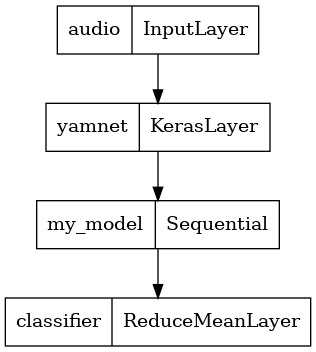

In [24]:
tf.keras.utils.plot_model(serving_model)

保存したモデルをロードして、期待どおりに機能することを確認します。

In [25]:
reloaded_model = tf.saved_model.load(saved_model_path)

さて、最後のテストです。サウンドデータに対して、モデルは正しい結果を返すでしょうか？

In [26]:
reloaded_results = reloaded_model(testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(reloaded_results)]
print(f'The main sound is: {cat_or_dog}')

The main sound is: cat


新しいモデルをサービング設定で試したい場合は、「serving_default」シグネチャを使用できます。

In [27]:
serving_results = reloaded_model.signatures['serving_default'](testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(serving_results['classifier'])]
print(f'The main sound is: {cat_or_dog}')


The main sound is: cat


## （任意）付加的ないくつかのテスト

モデルの準備が完了しました。

テストデータセットのYAMNetと比較してみましょう。

./datasets/ESC-50-master/audio/5-169983-A-5.wav


Waveform values: [-5.5530812e-08  1.5579258e-07 -1.3647924e-07 ... -1.0891285e-02
 -1.0113415e-02 -9.4338730e-03]


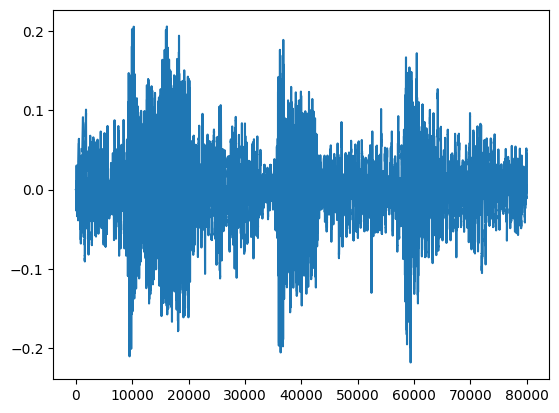

In [28]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 5]
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [29]:
# Run the model, check the output.
scores, embeddings, spectrogram = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]
top_score = class_scores[top_class]
print(f'[YAMNet] The main sound is: {inferred_class} ({top_score})')

reloaded_results = reloaded_model(waveform)
your_top_class = tf.math.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')

[YAMNet] The main sound is: Animal (0.583878219127655)


[Your model] The main sound is: cat (0.9891097545623779)


## 次のステップ

犬と猫のサウンドを分類するモデルを作成しました。同じ考え方で別のデータセットを使用すると、鳥の鳴き声に基づく[鳥の音響識別器](https://www.kaggle.com/c/birdclef-2021/)を構築するといったことが可能になります。

ソーシャルメディアで皆さんのプロジェクトを TensorFlow チームに知らせてください！
